# Estado Sólido I - Tarea 6
## Densidad de estados y transporte electrónico - Ej. 3

Román Tamez Vidal Tamayo Tamez - (tamoaltas)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
from tqdm import tqdm

In [2]:
import matplotlib
# Para el formato de las gráficas
matplotlib.rcParams.update(
    {
        "font.family": "serif",
        "text.usetex": True,
        "pgf.rcfonts": False,
        "axes.unicode_minus": False,
        "font.size": 12,
        "pgf.preamble": "\n".join([ # Aún más formato
        r"\usepackage[utf8]{inputenc}",
        r"\usepackage[T1]{fontenc}",
        ])
    }
)

### Parámetros

In [3]:
# Puntos de alta simetría
Gamma = np.array([0, 0, 0])
P = np.array([0.5, 0.5, 0.5])
H = np.array([1, 0, 0])
N = np.array([0.5, 0.5, 0])

sym_points = [Gamma, H, P, N, Gamma]
labels = [r'$\Gamma$', 'H', 'P', 'N', r'$\Gamma$']

In [4]:
def map(arr, new_min, new_max):
    '''
    Mapea un arrelo 'arr' a otro reescalado entre [new_min, new_max]
    '''
    return (arr - min(arr)) / (max(arr) - min(arr)) * (new_max - new_min) + new_min

In [5]:
# Número de puntos de evaluación entre cada trayectoria
num_p = 100

def construir_trayectorias(k_points, num_puntos=100):
    global num_p
    num_p = num_puntos

    # Construcción de las trayectorias
    k_path = [k_points[0]]
    k_dist = [0]
    for i in range(len(k_points)-1):
        segment = np.linspace(k_points[i], k_points[i+1], num_p)[1:]
        # print(segment[0],segment[-1])
        k_path.extend(segment)
        dist = np.linalg.norm(k_points[i+1] - k_points[i]) # Distancia entre los puntos de alta simetría
        ini = k_dist[-1] # Distancia a la que se iniciará
        dists = map(np.linspace(ini, dist + ini, num_p), i, i+1)
        k_dist.extend(dists[1:])

    k_path = np.array(k_path)

    return k_path, k_dist

In [6]:
def grapher(k_dist, bands, labels, title, doPlot=True):
    plt.figure(figsize=(6, 4))
    for band in bands:
        if doPlot:
            plt.plot(k_dist, band, 'b', alpha=0.4)
        else:
            plt.scatter(k_dist[:num_p], band[:num_p])
            plt.scatter(k_dist[num_p:num_p*2-1], band[num_p:num_p*2-1])
            plt.scatter(k_dist[num_p*2-1:], band[num_p*2-1:])


    indices = [i*(num_p-1) for i in range(len(sym_points))]
    ticks = [k_dist[i] for i in indices]
    plt.xticks(ticks,labels)
    for t in ticks:
        plt.axvline(x=t, color='gray', linestyle='--')
    
    plt.title(title)
    plt.ylabel("Energía (unidades norm.)")
    plt.xlabel(r'Trayectoria de $\mathbf{k}$')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

### Electrón libre

In [7]:
# Vectores de traslación
G_vectors = [
    np.array([0, 0, 0]),
    np.array([1, 0, 0]),
    np.array([1, 1, 0]),
]

k_path, k_dist = construir_trayectorias(sym_points, 100)
# Cálculo de las energías en el modelo del electrón libre para distintos G
def E_free_e(k, G=G_vectors[0]): 
    return np.linalg.norm(k + G)**2 

bands = []
for G in G_vectors:
    band = [E_free_e(k, G) for k in k_path]
    bands.append(band)

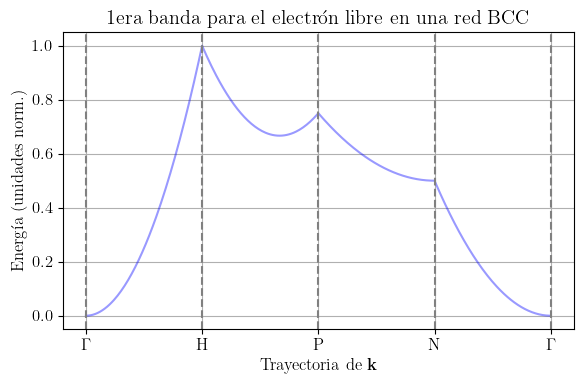

In [8]:
grapher(k_dist, [bands[0]], labels, "1era banda para el electrón libre en una red BCC", True)

#### Densidad de estados

In [9]:
kmax = 1  # Max k a calcular
sigma = 1.0       # Ensanchamiento para el alisado gaussiano
# Mallado en el k-espacio
k_vals = np.linspace(0, kmax, 200)
kx, ky, kz = np.meshgrid(k_vals, k_vals, k_vals, indexing='ij')
k_points = np.vstack([kx.ravel(), ky.ravel(), kz.ravel()]).T

In [10]:
E = [np.array([E_free_e(k, G) for k in tqdm(k_points)]) for G in G_vectors]

100%|██████████| 8000000/8000000 [00:18<00:00, 430570.84it/s]


In [11]:
def grapher2(k_dist, bands, energias_bandas, title):
    fig, ax = plt.subplots(1, 2, figsize=(10, 6), gridspec_kw={'width_ratios': [3, 1]}, sharey=True)

    # Gráficas estructura de bandas
    ax[0].plot(k_dist, bands[0], color='black')
    for band in bands:
        ax[0].plot(k_dist, band, color='black')

    # --------------  FORMATO  --------------
    indices = [i*(num_p-1) for i in range(len(sym_points))]
    ticks = [k_dist[i] for i in indices]
    ax[0].set_xticks(ticks,labels)
    for t in ticks:
        ax[0].axvline(x=t, color='gray', linestyle='--')

    ax[0].set_xlabel(r'Trayectoria de $\mathbf{k}$')
    ax[0].set_ylabel("Energía (unidades norm.)")
    ax[0].set_title(title)
    ax[0].grid()
    # ---------------------------------------

    # Gráficas densidad de estados
    num_bins = 200
    for e_banda in energias_bandas:
        # Se cuenta el número de energías en cierto rango
        dos, bins = np.histogram(e_banda, bins=num_bins, density=True)
        dos = gaussian_filter1d(dos, sigma=sigma)  # Smoothed DOS
        bin_centers = 0.5 * (bins[:-1] + bins[1:])
        ax[1].plot(dos, bin_centers)

    ax[1].set_xlabel('DOS')
    ax[1].set_title('Densidad de Estados')

    plt.tight_layout()
    plt.show()

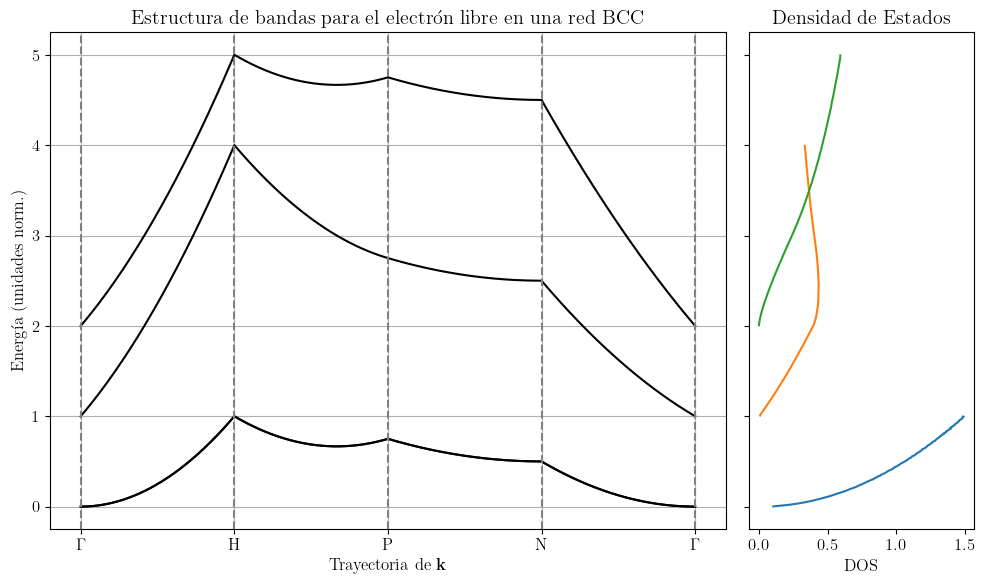

In [12]:
energias_bandas = [
            E[0][(E[0] >= 0) & (E[0] <= 1)],
            E[1][(E[1] >= 1) & (E[1] <= 4)],
            E[2][(E[2] >= 2) & (E[2] <= 5)]
    ]

grapher2(k_dist, bands, energias_bandas, "Estructura de bandas para el electrón libre en una red BCC")

### Amarre fuerte

In [13]:
def E_tight_binding(k, A = 0):
    return A + sum([np.cos(np.pi*k[i]) for i in range(3)])

bands = [[E_tight_binding(k) for k in k_path]]

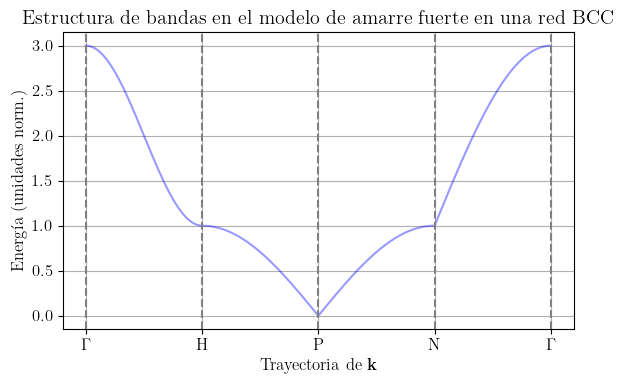

In [14]:
grapher(k_dist, bands, labels, "Estructura de bandas en el modelo de amarre fuerte en una red BCC", True)

#### Densidad de estados

In [15]:
E = np.array([E_tight_binding(k) for k in tqdm(k_points)])

100%|██████████| 8000000/8000000 [00:20<00:00, 388684.45it/s]


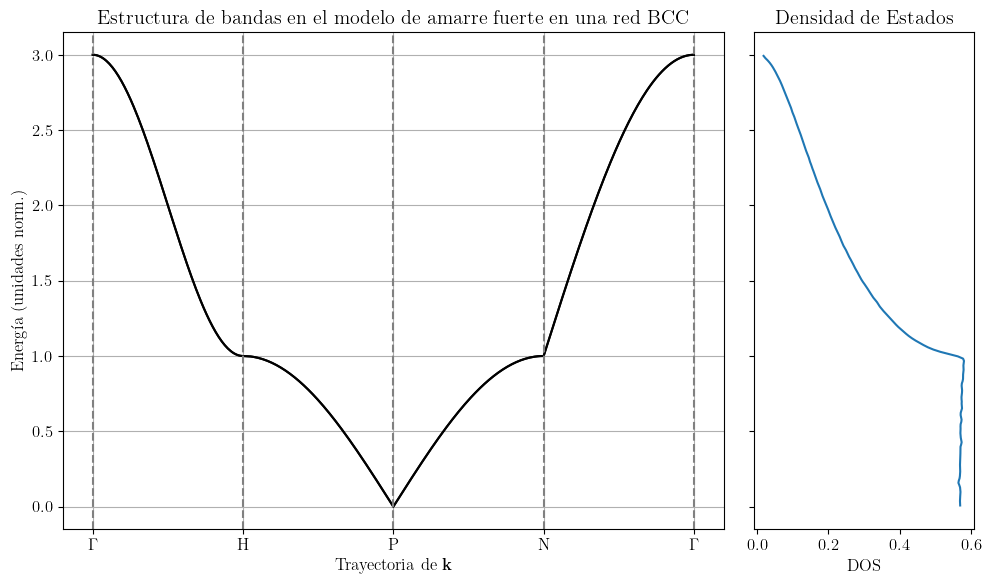

In [16]:
energias_bandas = [E[(E >= 0) & (E <= 3)]]

grapher2(k_dist, bands, energias_bandas, "Estructura de bandas en el modelo de amarre fuerte en una red BCC")